# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [7]:
from gpuocean.utils import Observation, DrifterPlotHelper

In [8]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-09-15T15_08_08"

true_trajectories = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

true_trajectories.read_pickle(os.path.join(truth_path, "truth_trajectories.pickle"))

In [9]:
true_trajectories.get_num_drifters()

100

## Ensemble drifter

In [10]:
ls = [7, 8]

In [11]:
from gpuocean.utils import DoubleJetCase

args_list = []
init_list = []

for l in ls:
    doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=2**l, nx=2**(l+1))
    doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

    args_list.append(doubleJetCase_args)
    init_list.append(doubleJetCase_init)

### Load Ensemble

In [12]:
source_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/MLDA/2023-09-19T14_10_37"

In [13]:
mlda_drifter60_path = os.path.join(source_path, "mldrifters_60")

mlda_trajectories60 = []
for f in os.listdir(mlda_drifter60_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(mlda_drifter60_path,f))
    
    mlda_trajectories60.append(trajectory)

In [14]:
mlda_drifter300_path = os.path.join(source_path, "mldrifters_300")

mlda_trajectories300 = []
for f in os.listdir(mlda_drifter300_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(mlda_drifter300_path,f))
    
    mlda_trajectories300.append(trajectory)

In [15]:
mlda_drifter900_path = os.path.join(source_path, "mldrifters_900")

mlda_trajectories900 = []
for f in os.listdir(mlda_drifter900_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(mlda_drifter900_path,f))
    
    mlda_trajectories900.append(trajectory)

In [ ]:
mlda_drifter1800_path = os.path.join(source_path, "mldrifters_1800")

mlda_trajectories1800 = []
for f in os.listdir(mlda_drifter1800_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(mlda_drifter1800_path,f))
    
    mlda_trajectories1800.append(trajectory)

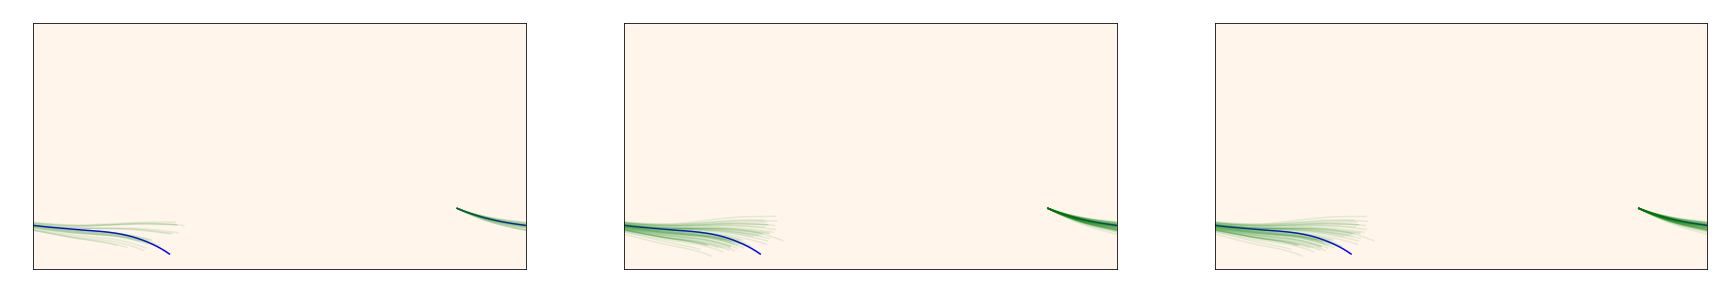

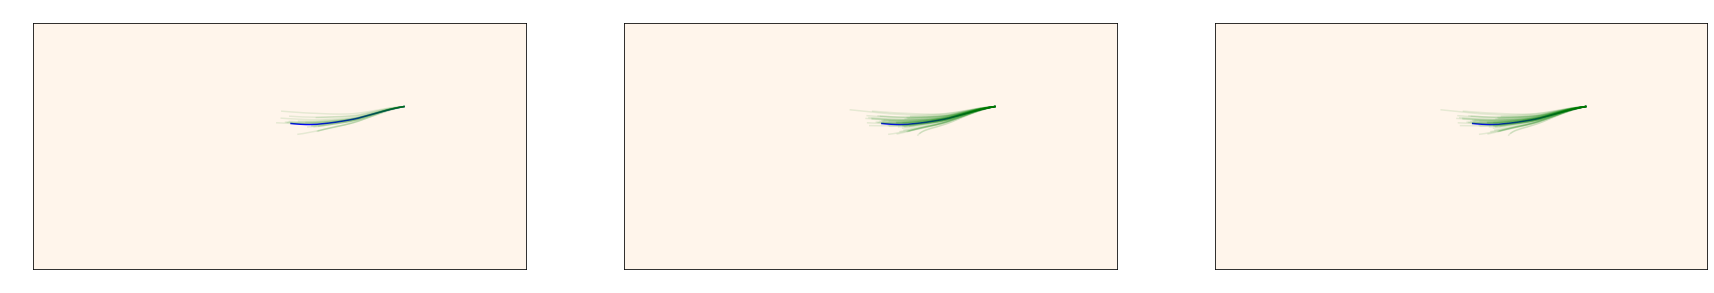

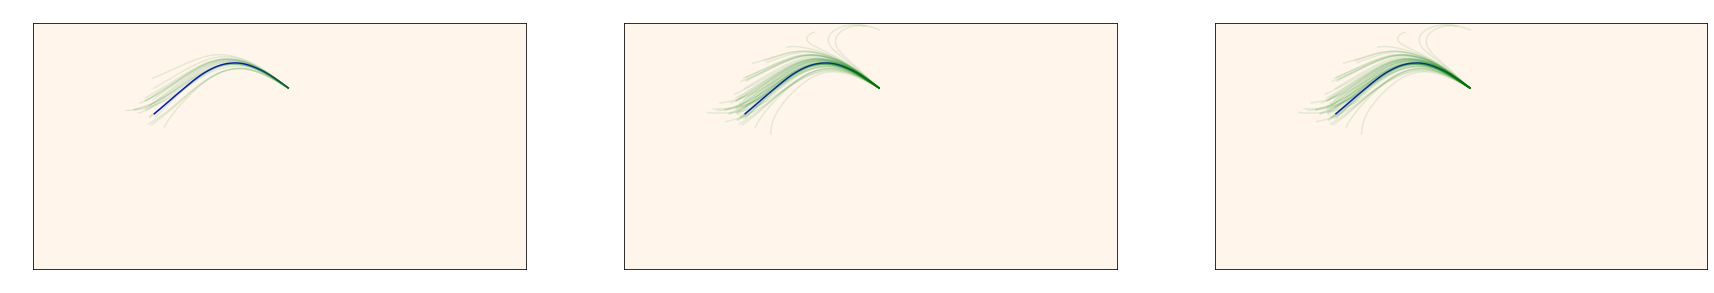

In [17]:
for d in range(3):

    fig, axs = plt.subplots(1,4, figsize=(30,10))
    axs[0].set_title("20 drifter")
    axs[1].set_title("50 drifter")
    axs[2].set_title("100 drifter")
    axs[3].set_title("200 drifter")

    for i in range(len(axs)):
        DrifterPlotHelper.background_from_grid_parameters(doubleJetCase_args["nx"], doubleJetCase_args["ny"], doubleJetCase_args["dx"], doubleJetCase_args["dy"], ax=axs[i])
        DrifterPlotHelper.add_drifter_on_background(axs[i], true_trajectories, drifter_id=d)

    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[0], mlda_trajectories60[:20], drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[1], mlda_trajectories60[:50], drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[2], mlda_trajectories60[:100], drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[3], mlda_trajectories60[:200], drifter_id=d, color='Green', alpha=0.1)

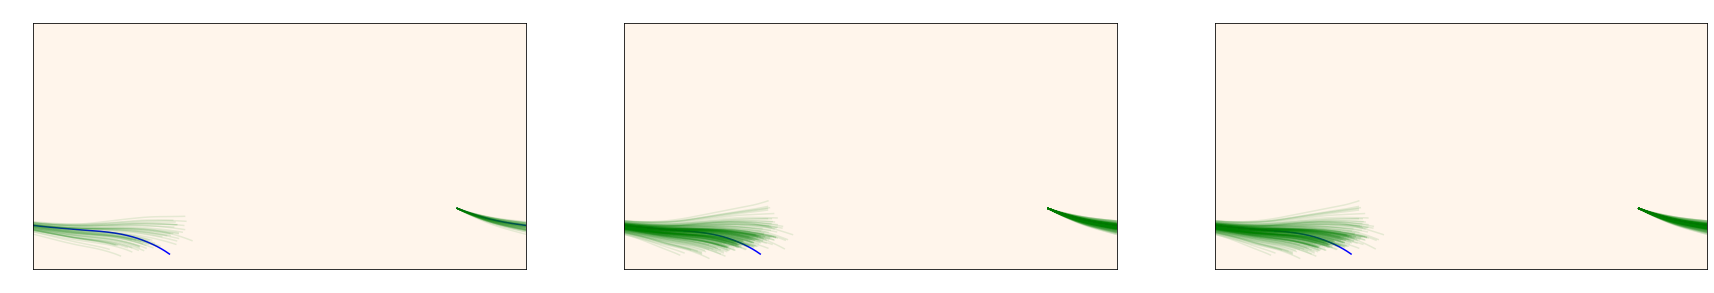

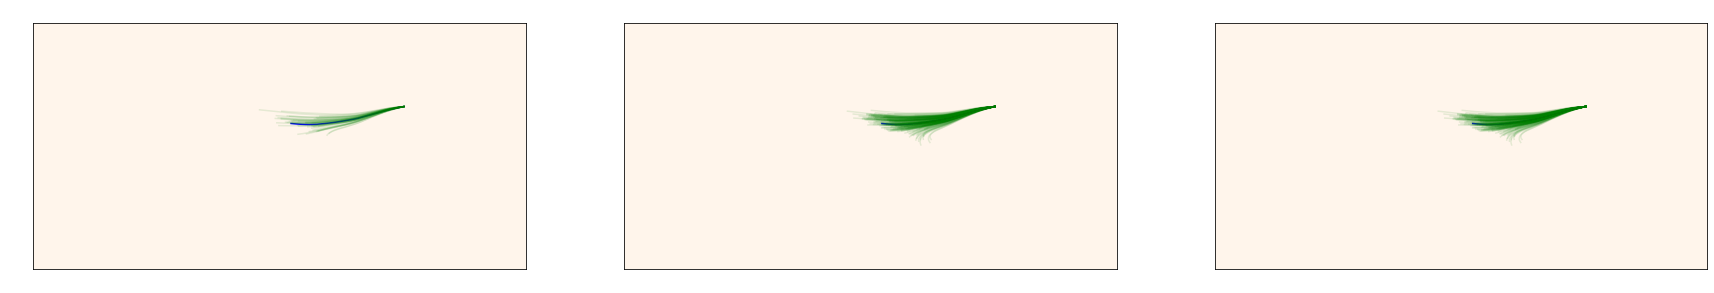

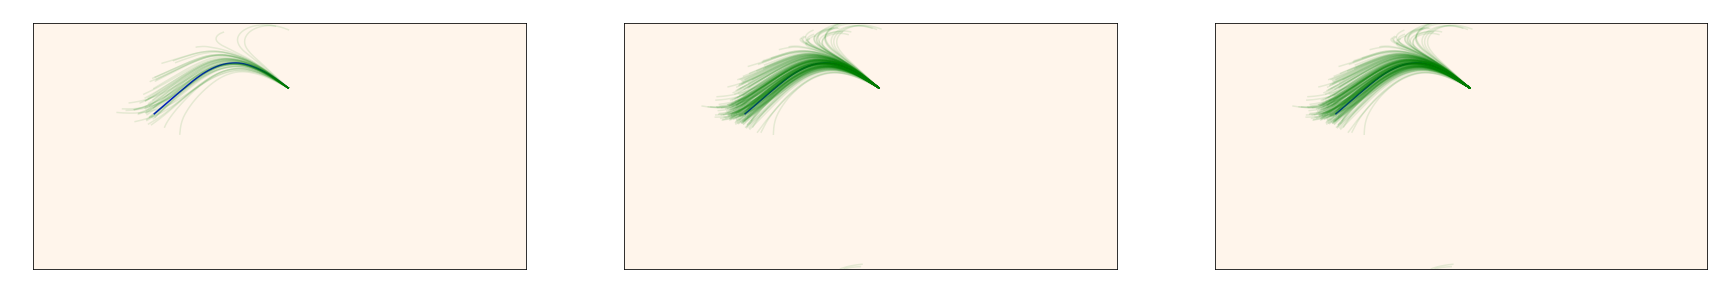

In [18]:
for d in range(3):

    fig, axs = plt.subplots(1,3, figsize=(30,10))
    axs[0].set_title("drifter_dt 60")
    axs[1].set_title("drifter_dt 300")
    axs[2].set_title("drifter_dt 900")
    axs[3].set_title("drifter_dt 1800")

    for i in range(len(axs)):
        DrifterPlotHelper.background_from_grid_parameters(doubleJetCase_args["nx"], doubleJetCase_args["ny"], doubleJetCase_args["dx"], doubleJetCase_args["dy"], ax=axs[i])
        DrifterPlotHelper.add_drifter_on_background(axs[i], true_trajectories, drifter_id=d)

    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[0], mlda_trajectories60, drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[1], mlda_trajectories300, drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[2], mlda_trajectories900, drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[3], mlda_trajectories1800, drifter_id=d, color='Green', alpha=0.1)